In [1]:
# %load_ext cudf.pandas

# %pip install seaborn
# %pip install Sastrawi
# %pip install wordcloud
# %pip install torch
# %pip install transformers
# %pip install nltk
# %pip install tensorflow
# %pip install gensim --upgrade
%pip install Sastrawi
# !unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.8 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
# basic library
import pandas as pd
import numpy as np
import re
import string
import os
# import seaborn as sns
import matplotlib.pyplot as plt
# from wordcloud import WordCloud

# model
# import torch
# from torch.utils.data import DataLoader, TensorDataset

# stop words
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# stememer
# from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# nltk corpus
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# tokenizer
from transformers import BertTokenizer
from tokenizers import Tokenizer

# vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# from gensim.models import Word2Vec

# other preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences

# training pipline
import tensorflow as tf
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

# label encoding
label_type = ['NotPromotion', 'Promotion']

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
2025-05-04 14:29:51.404285: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746368991.594511      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746368991.648238      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
combined_data = pd.read_csv('/kaggle/input/dataset-scraping-sendiri/dataset_combined_new - dataset_combined_new.csv', sep=',').dropna()
combined_data = combined_data.drop_duplicates().reset_index(drop=True)
training_data = pd.read_csv('/kaggle/input/dataset-scraping-sendiri/train.csv', sep=',').dropna()
testing_data = pd.read_csv('/kaggle/input/dataset-scraping-sendiri/test.csv', sep=',').dropna()
validation_data = pd.read_csv('/kaggle/input/dataset-scraping-sendiri/val.csv').dropna()

# training_data = training_data.sample(frac = 1)
training_data.head()

,text,label
0,Mencari pengalaman daring yang lancar? AERO88 ...,1
1,Itu kayanya di kasih tanda deh yg bisa di lewa...,0
2,Whatsapp Telegram Livechat Daftar Login Hdtoto...,1
3,KO SELASA SI BABG,0
4,"TERLEPAS DARI GAME NYA YANG BAGUS, SEMOGA BANG...",0


In [4]:
print("train isna:",training_data['text'].isna().sum())
print("test isna:",testing_data['text'].isna().sum())
print("val isna:",validation_data['text'].isna().sum())

print(training_data[training_data['text'].isna()][['text', 'label']])


train isna: 0
test isna: 0
val isna: 0
Empty DataFrame
Columns: [text, label]
Index: []


# Preprocessing

In [5]:
stop_factory = StopWordRemoverFactory()
stopwords = stop_factory.get_stop_words()
custom_stopwords = ['aku', 'yg', 'kamu']
drop_stopwords = ['pula', 'pasti', 'amat', 'ingin', 'sampai']

stopwords += custom_stopwords
stopwords = [word for word in stopwords if word not in drop_stopwords]

pattern = r"[^A-Za-z ]"

print(stopwords)

['yang', 'untuk', 'pada', 'ke', 'para', 'namun', 'menurut', 'antara', 'dia', 'dua', 'ia', 'seperti', 'jika', 'jika', 'sehingga', 'kembali', 'dan', 'tidak', 'ini', 'karena', 'kepada', 'oleh', 'saat', 'harus', 'sementara', 'setelah', 'belum', 'kami', 'sekitar', 'bagi', 'serta', 'di', 'dari', 'telah', 'sebagai', 'masih', 'hal', 'ketika', 'adalah', 'itu', 'dalam', 'bisa', 'bahwa', 'atau', 'hanya', 'kita', 'dengan', 'akan', 'juga', 'ada', 'mereka', 'sudah', 'saya', 'terhadap', 'secara', 'agar', 'lain', 'anda', 'begitu', 'mengapa', 'kenapa', 'yaitu', 'yakni', 'daripada', 'itulah', 'lagi', 'maka', 'tentang', 'demi', 'dimana', 'kemana', 'sambil', 'sebelum', 'sesudah', 'supaya', 'guna', 'kah', 'pun', 'sedangkan', 'selagi', 'sementara', 'tetapi', 'apakah', 'kecuali', 'sebab', 'selain', 'seolah', 'seraya', 'seterusnya', 'tanpa', 'agak', 'boleh', 'dapat', 'dsb', 'dst', 'dll', 'dahulu', 'dulunya', 'anu', 'demikian', 'tapi', 'juga', 'nggak', 'mari', 'nanti', 'melainkan', 'oh', 'ok', 'seharusnya', 's

In [6]:
def preprocess_text(texts):
    sentences=[]
    for index, text in enumerate(texts):

        word_list = word_tokenize(text)
        word_list = [word for word in word_list if word not in stopwords]
        
        text = ' '.join(word_list)
        texts[index] = text
        sentences.append(word_list)
    return texts, sentences

In [7]:
texts_raw_train = training_data['text'].values.copy()
texts_raw_val = validation_data['text'].values.copy()
texts_raw_test = testing_data['text'].values.copy()
texts_raw_combined = combined_data['text'].values.copy()
y_train = training_data['label'].values.copy()
y_val = validation_data['label'].values.copy()
y_test = testing_data['label'].values.copy()

In [8]:
texts_train,sentences = preprocess_text(texts_raw_train)
texts_val,_ = preprocess_text(texts_raw_val)
texts_test,_ = preprocess_text(texts_raw_test)
texts_combined,_ = preprocess_text(texts_raw_combined)

texts_train

array(['Mencari pengalaman daring lancar ? AERO88 mungkin solusinya .',
       'Itu kayanya kasih tanda deh lewatin apa ngga , contohnya kerucut+tong sampah biru',
       'Whatsapp Telegram Livechat Daftar Login Hdtoto Beranda Slot Online Live Casino Sportsbook Arcade Togel Poker slider Jackpot Daily Wins Gates of Olympus Bonanza Gold < Starlight Princess Sweet power thor megaways Treasure Wild Aztec Gems Gatot Kaca Popular Games bowl Mahjong Ways Break Away Lucky Wilds Koi Gate 1000 Wishes Gem Saviour Conquest Chronicles X Up Gold Blitz Elven Roma Silverback Multiplier Mountain Fiery Sevens Hot Phoenix Rises Neko Fortune Tiger garuda Treasures Bandito fireworks Dreams Macau Rooster Rumble > Platform Hiburan Terbaru No.1 Indonesia Penyedia pragmatic pgsoft habanero cq9 spadegaming ttg joker microgaming ion sexy gaming allbet idnlive saba sports Metode Pembayaran Transfer Bank Pulsa E-Money ©2024 Hdtoto . All rights reserved | 18+',
       ..., 'Kerennn',
       'Saya merekomendasikan ρ

# Tokenization & Vectorizer

In [ ]:
# Define parameters

# EMBEDDING_DIM = 256
# MAX_LEN = 128

## TFIDF Vectorizer 

In [17]:
tfidf_vectorizer = TfidfVectorizer(max_features=3000)
tfidf_vectorizer.fit(texts_train)

train_texts = tfidf_vectorizer.transform(texts_train).toarray()
# tfidf_vectorizer.fit(texts_val)
val_texts = tfidf_vectorizer.transform(texts_val).toarray()
# tfidf_vectorizer.fit(texts_test)
test_texts = tfidf_vectorizer.transform(texts_test).toarray()

In [18]:
train_texts = train_texts.reshape(train_texts.shape[0], train_texts.shape[1], 1)
val_texts = val_texts.reshape(val_texts.shape[0], val_texts.shape[1], 1)
test_texts = test_texts.reshape(test_texts.shape[0], test_texts.shape[1], 1)


In [19]:
VOCAB_SIZE = train_texts.shape[1]
print(VOCAB_SIZE)

print(train_texts.shape)  # Shape: (num_samples, num_features, 1)
print(val_texts.shape)  # Shape: (num_samples, num_features, 1)
print(test_texts.shape)  # Shape: (num_samples, num_features, 1)

3000
(2736, 3000, 1)
(343, 3000, 1)
(342, 3000, 1)


# Training

In [20]:
# LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional, Input
from tensorflow.keras import layers
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

drop_value = 0.2

In [21]:
train_texts.shape[1:]

(3000, 1)

In [22]:
def build_model():
    # Input layer with the correct shape from train_texts
    sentence_indices = Input(shape=train_texts.shape[1:], dtype='float32')  # Changed dtype to float32
    
    # Remove embedding layer since we're using TFIDF vectors
    # We're already using vectorized text data
    
    # LSTM layers
    X = SpatialDropout1D(drop_value)(sentence_indices)
    X = Bidirectional(LSTM(64, return_sequences=True))(X)
    X = Dropout(0.3)(X)
    X = LSTM(32, return_sequences=True)(X)
    X = Dropout(0.3)(X)
    X = Flatten()(X)
    # X = GlobalAveragePooling1D()(X)
    
    # Dense layers
    X = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(X)
    X = Dropout(0.2)(X)
    X = Dense(1, activation='sigmoid')(X)
    
    # Model definition
    model = Model(inputs=sentence_indices, outputs=X)
    
    return model

model = build_model()
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 3000, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_1                  │ (None, 3000, 1)             │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 3000, 128)           │          33,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 3000, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 3000, 32)            │          20,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 3000, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 96000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │       3,072,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,126,465 (11.93 MB)

 Trainable params: 3,126,465 (11.93 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.685027541311968, 1: 1.851150202976996}

In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

checkpoint_callback = ModelCheckpoint(filepath='./best_model_checkpoint.keras',  
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      save_weights_only=False,  # Save full model (architecture + weights)
                                      verbose=1)
# early_stop = EarlyStopping(monitor='val_loss', patience=3)

num_epochs = 100
history = model.fit(
    train_texts,
    y_train,
    validation_data=(val_texts,y_val),
    epochs=num_epochs,
    callbacks=[checkpoint_callback],
    class_weight=class_weights
)


Epoch 1/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.5560 - loss: 1.2411
Epoch 1: val_accuracy improved from -inf to 0.84548, saving model to ./best_model_checkpoint.keras
86/86 ━━━━━━━━━━━━━━━━━━━━ 33s 335ms/step - accuracy: 0.5565 - loss: 1.2402 - val_accuracy: 0.8455 - val_loss: 1.0202
Epoch 2/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.5929 - loss: 0.9665
Epoch 2: val_accuracy did not improve from 0.84548
86/86 ━━━━━━━━━━━━━━━━━━━━ 28s 322ms/step - accuracy: 0.5932 - loss: 0.9661 - val_accuracy: 0.3907 - val_loss: 0.8563
Epoch 3/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.5882 - loss: 0.8253
Epoch 3: val_accuracy did not improve from 0.84548
86/86 ━━━━━━━━━━━━━━━━━━━━ 28s 322ms/step - accuracy: 0.5883 - loss: 0.8250 - val_accuracy: 0.3703 - val_loss: 0.7740
Epoch 4/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.6393 - loss: 0.7495
Epoch 4: val_accuracy improved from 0.84548 to 0.87755, saving model to ./best_model_checkpoint.k

In [26]:
from tensorflow.keras.models import load_model
model = load_model("best_model_checkpoint.keras")

model.save("LSTM_TFIDF.keras")

# Eval

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("../Model/LSTM_TFIDF.keras")

In [27]:
model.evaluate(test_texts, y_test, verbose=0)


[0.25282302498817444, 0.9415204524993896]

In [28]:
best_epoch = np.argmax(history.history['val_accuracy']) + 1
best_epoch

66

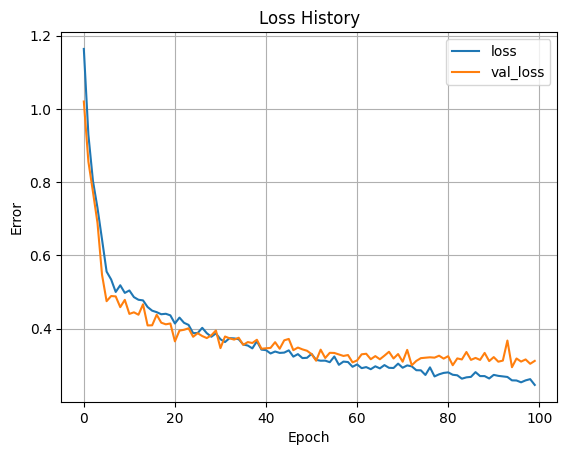

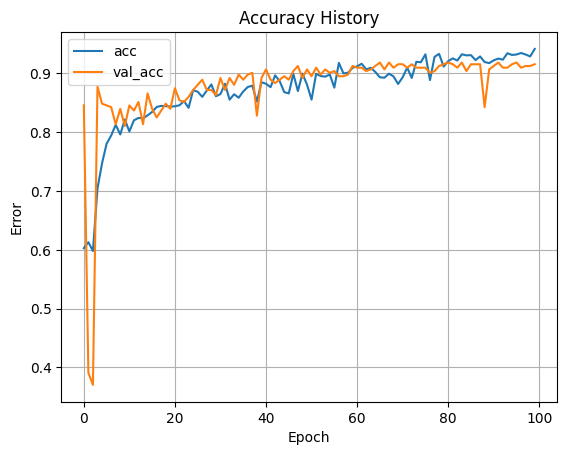

In [29]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
# plt.ylim([0, 0.2])
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.title("Loss History")
plt.show()

plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.title("Accuracy History")
plt.grid(True)

In [30]:
from sklearn.metrics import precision_recall_curve, f1_score
from sklearn.metrics import average_precision_score

y_probs = model.predict(test_texts)
y_probs = y_probs.flatten()

precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

best_idx = f1s.argmax()
best_threshold = thresholds[best_idx]

print(f"Best Threshold: {best_threshold:.4f}")
print(f"Best F1-Score: {f1s[best_idx]:.4f}")

ap_score = average_precision_score(y_test, y_probs)
print(f"Average Precision (AP) Score: {ap_score:.4f}")


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step
Best Threshold: 0.5956
Best F1-Score: 0.8889
Average Precision (AP) Score: 0.9454


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step
Accuracy Score: 0.9444444444444444
F1 Score: 0.888888888888889
Recall Score: 0.9620253164556962
Precision Score: 0.8260869565217391
Classification Report: 
              precision    recall  f1-score   support

NotPromotion       0.94      0.99      0.96       250
   Promotion       0.96      0.83      0.89        92

    accuracy                           0.94       342
   macro avg       0.95      0.91      0.93       342
weighted avg       0.95      0.94      0.94       342

Confusion Matrix:



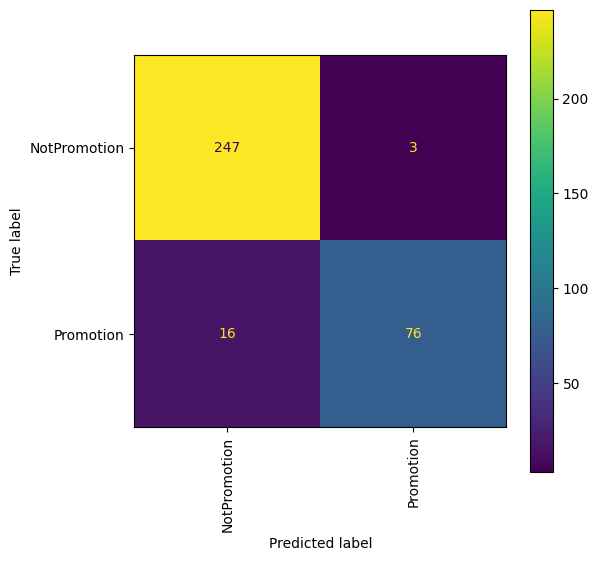

In [31]:
pred = model.predict(test_texts)
y_pred = [0 if pred < best_threshold else 1 for pred in pred]

print(f"Accuracy Score: {accuracy_score(y_pred, y_test)}")
print(f"F1 Score: {f1_score(y_pred, y_test)}")
print(f"Recall Score: {recall_score(y_pred, y_test)}")
print(f"Precision Score: {precision_score(y_pred, y_test)}")
print(f"Classification Report: \n{classification_report(y_test, y_pred, target_names=label_type)}")

display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels = label_type)

fig, ax = plt.subplots(figsize=(6,6))
print(f"Confusion Matrix:\n")
display.plot(ax=ax, xticks_rotation='vertical')

In [32]:
for idx,i in enumerate(y_pred):
    if i != y_test[idx]:
        print(idx+1,")❌pred:", i, "| label:", y_test[idx], texts_test[idx])
        continue
    print(idx+1,") pred:", i, "| label:", y_test[idx], texts_test[idx])

1 ) pred: 1 | label: 1 INFO CINA777APK CINA777RTP CINA777Logo24/11/2024 ( Min ) 14.56 ( GMT+07 ) Versi MobileVersi WAP ( NEX4D ) Nama PenggunaKata SandiLupa Kata Sandi ? DaftarHomeTogelHot GamesSlotsLive CasinoOlahragaCrash GameArcadePokerE-SportsSabung AyamPromosiWelcome to situs resmi CINA777 | Kami membayar berapapun kemenangan player.HasilPasaranBuku MimpiHasil TerakhirStatistik MarketGame PopulerMahjong Wins 3 – Black ScatterMAINMahjong Wins 3 – Black ScatterMahjong WaysMAINMahjong WaysMighty HerculesMAINMighty HerculesSlot88 BonanzaMAINSlot88 BonanzaLe PharaohMAINLe PharaohPirate Quest 1000MAINPirate Quest 1000SixSixSixMAINSixSixSixWay of NinjaMAINWay of Ninja888 GoldMAIN888 GoldMahjong Ways 2MAINMahjong Ways 2Gates of Olympus 1000™MAINGates of Olympus 1000™Wild Bounty ShowdownMAINWild Bounty ShowdownLucky Twins NexusMAINLucky Twins NexusNexus Koi GateMAINNexus Koi GateThe CryptMAINThe CryptLucky Twins Power ClustersMAINLucky Twins Power ClustersMentalMAINMentalFortune Gems 2MAIN

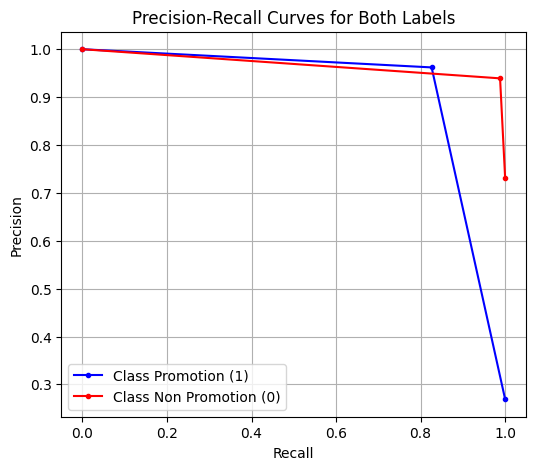

In [33]:
from sklearn.metrics import precision_recall_curve, auc

# Compute precision-recall values for class 1 (positive class)
precision_1, recall_1, _ = precision_recall_curve(y_test, y_pred)

# Compute precision-recall values for class 0 (negative class)
y_scores_neg = 1 - np.array(y_pred)  # Since model predicts class 1 probabilities, class 0 is (1 - probability)
precision_0, recall_0, _ = precision_recall_curve(1 - y_test, y_scores_neg)

# Plot Precision-Recall curves for both classes
plt.figure(figsize=(6, 5))
plt.plot(recall_1, precision_1, marker='.', label=f'Class Promotion (1)', color='blue')
plt.plot(recall_0, precision_0, marker='.', label=f'Class Non Promotion (0)', color='red')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Both Labels')
plt.legend()
plt.grid()
plt.show()

In [ ]:
def predict_sentiment(text):
    use_text,_ = preprocess_text(text)
    tfidf_vectorizer.fit(use_text)
    use_text = tfidf_vectorizer.transform(use_text).toarray()
    use_texts = use_text.reshape(use_text.shape[0], use_text.shape[1], 1)
    # inputs = tokenizer(use_text, padding=True, truncation=True, return_tensors='tf', max_length=512)
    # use_text = tokenizer.texts_to_sequences(use_text)
    # use_text = pad_sequences(use_text, maxlen=MAX_LEN, padding='post', truncating='post')
    print(use_texts.shape)
    pred = model.predict(use_texts)
    # pred_labels = tf.argmax(pred, axis=1)
    pred_labels = [0 if pred < best_threshold else 1 for pred in pred]
    # print(pred)
 
    pred_labels = [label_type[label] for label in pred_labels]
    for index, preds in enumerate(pred_labels):
        print(f"{text[index]}: {preds}")
text = [
    "Aku adalah seorang mahasiswa",
    "Judi Online Disebut Masuk Tahap Sosial, Cak Imin: 8,8 Juta Pasien Minta Direhabilitasi Jumat, 15 Nov",
    "Gacor xxtoto menang pasti dibayar",
    "dp jd jt buruan gas garansi meteorwin",
    "gacor pasti menang di xxtoto",
    "top up di kantorbola pasti gampang menangnya",
    "gratis koin buruan topup di agencasinoindonesia",
    "gratis koin buruan topup di fairbet88.com, segera daftarkan akun anda",
    "DEWA-DORA tuh situs yang paling enak withdraw tiap hari! 😖 😣",
    "DEWA-DORA tuh situs    yang paling gampang narik tiap hari! 😖 😣",
    "Gua setia maen di DEWADORA, tempat terbaik!",
    "kantorbola99.club - Mau Jackpot x50 x100 x500 x1000 pasti dibayar ? gabung dan Menang berapapun dibayar.",
    "dapatkan banyak rejekii di DEWADORА!"
]
predict_sentiment(text)